# Data Generator

The data generator module supports generating both time series and tabular causal graphs, and data of continuous and discrete types. 

### Graph Generation

For both, tabular and time series data, we support two methods for generating synthetic causal graphs.

**Tabular**: GenerateRandomTabularSEM, GenerateSparseTabularSEM

**Time Series**: GenerateRandomTimeseriesSEM, GenerateSparseTimeSeriesSEM

The main difference between GenerateRandomSEM and GenerateSparseSEM is that the former requires the maximum number of parents when generating a random SEM, while the latter requires the graph density.

Their descriptions are as follows:

- **GenerateRandomTabularSEM**: Generate a random structural equation model (SEM) for tabular data. It takes the following arguments:
    1. var_names (List of str): Names of variables in the SEM in the form of a list of str.
    2. max_num_parents (int): Maximum number of causal parents allowed in the randomly generated SEM. (default: 4)
    3. seed (int): Random seed used for reproducibility.
    4. fn (Callable): Function applied to a parent variable when generating child variable data. Default: Linear 
        function for linear causal relation.


- **GenerateSparseTabularSEM**: Generate a structural equation model (SEM) for tabular data using the following procedure:
    For N nodes, enumerate them from 0-N. For all i,j between 0-N, if i < j, the edge from vi 
    to vj exists with probability graph_density, and if i >= j there cannot be an edge betwen them. It takes the following arguments:
    1. var_names (List of str): Names of variables in the SEM in the form of a list of str.
    2. graph_density (float): Probability that an edge between node i and j exists.
    3. seed (int): Random seed used for reproducibility.
    4. fn (Callable): Function applied to a parent variable when generating child variable data. Default: Linear 
        function for linear causal relation.
    5. coef (float): coefficient of parent variables in the randomly generated SEM. Note: larger values may 
        cause exploding values in data array for some seeds.



- **GenerateRandomTimeseriesSEM**: Generate a random structural equation model (SEM) for time series data using the following procedure:
    Randomly divide variables into non-overlapping groups of size between 3 and num_vars. Then randomly
    create edges between a preceeding group and a following group such that max_num_parents is never exceeded. It takes the following arguments:
    1. var_names (List of str): Names of variables in the SEM in the form of a list of str.
    2. max_num_parents (int): Maximum number of causal parents allowed in the randomly generated SEM. (default: 4)
    2. max_lag (int): Maximum time lag between parent and child variable allowed in the randomly generated SEM. (default: 4)
    3. seed (int): Random seed used for reproducibility.
    4. fn (Callable): Function applied to a parent variable when generating child variable data. Default: Linear 
        function for linear causal relation.


- **GenerateSparseTimeSeriesSEM**: Generate a structural equation model (SEM) for time series data using the following procedure:
    For N nodes, enumerate them from 0-N. For each time lag (until max_lag), for all i,j between 0-N, if i < j, 
    the edge from vi to vj exists with probability graph_density, and if i >= j there cannot be an edge 
    betwen them. It takes the following arguments:
    1. var_names (List of str): Names of variables in the SEM in the form of a list of str.
    2. graph_density (float): Probability that an edge between node i and j exists.
    3. max_lag (int): Maximum time lag between parent and child variable allowed in the randomly generated SEM. Must be non-negative.
    4. seed (int): Random seed used for reproducibility.
    5. fn (Callable): Function applied to a parent variable when generating child variable data. Default: Linear 
        function for linear causal relation.
    6. coef (float): coefficient of parent variables in the randomly generated SEM. Note: larger values may 
        cause exploding values in data array for some seeds.
        

### Data Generation

The function **DataGenerator** is used for generating data samples for a given structural equation model (SEM). The function has several arguments:

1. sem (Python dictionary): specifies the causal graph in the form of aa Python Dctionary and implicitly contains the information whether the data is time series or tabular data. 
2. T (int): specifies the number of sample or length of time series, depending on whether the data i tabular or time series.
3. noise_fn (List of Callable): List of functions each of which takes t as input and that returns a random vector of length t. The ith index corresponds to the ith key in sem. (default: list of np.random.randn)
4. intervention (Python dictionary): Dictionary of format: {1:np.array, ...} containing only keys of intervened variables with the value being the array of length T with interventional values. Set values to np.nan to leave specific time points of a variable un-intervened.
5. discrete (bool or Python dictionary): When bool, it specifies whether all the variables are discrete or all of them are continuous. If true, the generated data is discretized into nstates uniform bins (default: False). Alternatively, if discrete is specified as a dictionary, then the keys of this dictionary must be the variable names and the value corresponding to each key must be True or False. A value of False implies the variable is continuous, and discrete otherwise. (default: False)
6. nstates (int): When discrete is True, the nstates specifies the number of bins to use for discretizing the data (default=10). Ignored for continuous data.
7. seed (int): Set the seed value for random number generation for reproduciblity (default: 1).

As an example, for tabular data, the following is a sample SEM,
$$A = \mathcal{N}_A()$$
$$B = k_1 \times F_1(A) + \mathcal{N}_B()$$
$$C = k_2 \times F_2(A) + k_3 \times F_3(B) + \mathcal{N}_C()$$

where $\mathcal{N}_i$'s are functions that return random samples from some distribution (E.g. Gaussain), $k_i$'s are constants, and $F_i$'s are callable functions that transforms the argument variable value. 




In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pickle as pkl
from causalai.misc.misc import plot_graph
from causalai.data.data_generator import DataGenerator, GenerateRandomTabularSEM, GenerateRandomTimeseriesSEM
from causalai.data.data_generator import GenerateSparseTimeSeriesSEM

## Graph Generation

Here we show an example of generating a graph for tabular and time series data.

In [2]:
sem_tabular = GenerateRandomTabularSEM(var_names=['a', 'b', 'c', 'd', 'e', 'f'],
                                       max_num_parents=4, seed=0, fn = lambda x:x)
sem_tabular

{'a': [('c', 0.1, <function __main__.<lambda>(x)>),
  ('f', 0.1, <function __main__.<lambda>(x)>)],
 'b': [('f', 0.1, <function __main__.<lambda>(x)>)],
 'c': [('b', 0.1, <function __main__.<lambda>(x)>)],
 'd': [('f', 0.1, <function __main__.<lambda>(x)>)],
 'e': [('b', 0.1, <function __main__.<lambda>(x)>),
  ('f', 0.1, <function __main__.<lambda>(x)>)],
 'f': []}

SEM is provided as a Python dictionary with variable names as keys, and the list of children as values. Specifically, each child is of the format (parent, coef, function), as explained in the example above under Data Generation in the equations for an SEM.

In [3]:
sem_time_series = GenerateSparseTimeSeriesSEM(var_names=['a', 'b', 'c', 'd', 'e', 'f'],
                                       graph_density=0.1, max_lag=4, seed=0, fn = lambda x:x, coef = 0.1)

sem_time_series

{'a': [],
 'b': [],
 'c': [(('b', -1), 0.1, <function __main__.<lambda>(x)>),
  (('a', -2), 0.1, <function __main__.<lambda>(x)>)],
 'd': [],
 'e': [(('c', -2), 0.1, <function __main__.<lambda>(x)>)],
 'f': [(('c', -3), 0.1, <function __main__.<lambda>(x)>)]}

SEM is provided as a Python dictionary with variable names as keys, and the list of children as values. Specifically, each child is of the format ((parent, time_lag), coef, function), as explained in the example above under Data Generation in the equations for an SEM. Note that time_lag is specified as -k (e.g. -1) which is to be read as t-1, where t is the current time step of the parent. So for node 'c', one of the parents is ('b',-1), which implies b[t-1], which is a parent of c[t].

## Data Generation without intervention

Let's start with the simple case of data generation without any interventions.

In [4]:
fn = lambda x:x
F1=F2=F3 = fn
k = 0.1
k1=k2=k3=k
noise_fn = np.random.randn
noise_fn_a= noise_fn_b= noise_fn_c = noise_fn
sem_tabular = {
        'a': [], 
        'b': [('a', k1, F1)], 
        'c': [('a', k2, F2), ('b', k3, F3)],
        }

sem_time_series = {
        'a': [], 
        'b': [(('a', -1), k1, F1)], 
        'c': [(('a', -2), k2, F2), (('b', -2), k3, F3)],
        }


T = 5000 # number of samples in case of tabular data, and length of time series in case of time series data
data_tabular, var_names_tabular, graph_gt_tabular = DataGenerator(sem_tabular, T=T, seed=0, discrete=False,\
                                            noise_fn=[noise_fn_a, noise_fn_b, noise_fn_c])

data_time_series, var_names_time_series, graph_gt_time_series = DataGenerator(sem_time_series, T=T,\
                                                            seed=0, discrete=False)


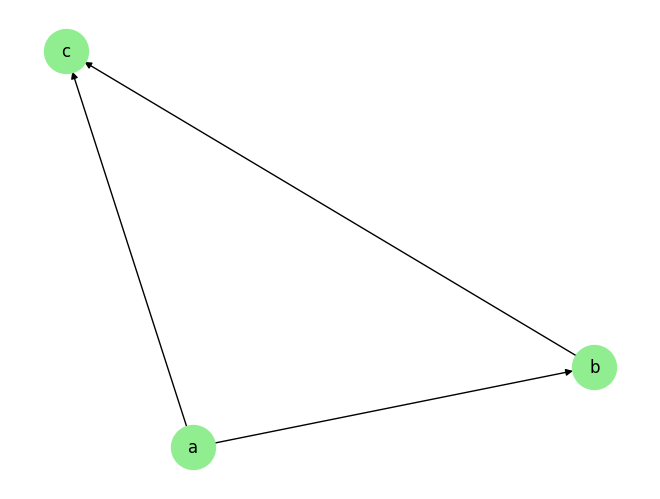

({'a': [], 'b': ['a'], 'c': ['a', 'b']}, ['a', 'b', 'c'])

In [5]:
plot_graph(graph_gt_tabular)
graph_gt_tabular, var_names_tabular

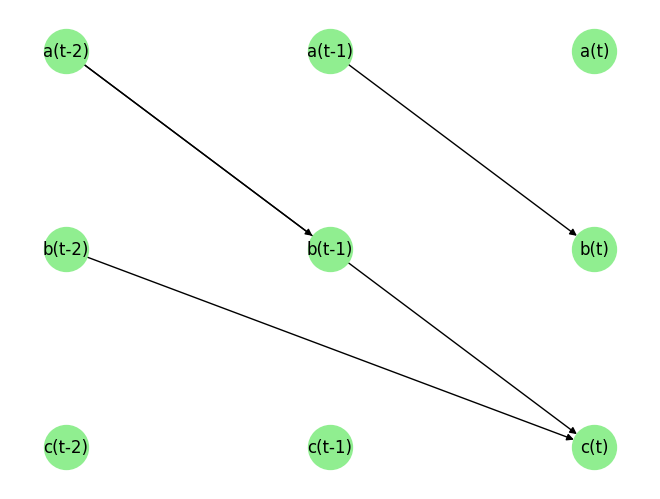

({'a': [], 'b': [('a', -1)], 'c': [('a', -2), ('b', -2)]}, ['a', 'b', 'c'])

In [6]:
plot_graph(graph_gt_time_series)
graph_gt_time_series, var_names_time_series

## Data Generation with intervention

It is also possible to generate data with interventions. For instance, below is the code that generates data without any intervention.

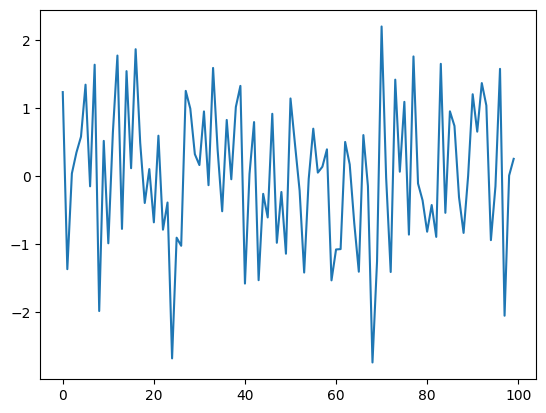

In [7]:
fn = lambda x:x
F1=F2=F3 = fn
k = 0.1
k1=k2=k3=k
sem_tabular = {
        'a': [], 
        'b': [('a', k1, F1)], 
        'c': [('a', k2, F2), ('b', k3, F3)],
        }
T = 5000 # number of samples in case of tabular data, and length of time series in case of time series data
data_tabular, var_names_tabular, graph_gt_tabular = DataGenerator(sem_tabular, T=T, seed=0, discrete=False)

plt.plot(data_tabular[-100:,1], label='b')
plt.show()

Now, if we want to generate data corresponding to the same data generating process as above, except, we now want to intervene a specific variable, it can be done by specifying the argument intervention as follows.

In [8]:
t='b' 

intervention = 2*np.ones(T)
intervention_data,_,_ = DataGenerator(sem_tabular, T=T, seed=0, intervention={t:intervention})

Note how the value of the argument seed is the same in both the data generation with and without intervention. This is important to ensure that the data is generated via the same process in both case, with the only difference being the intervention in the latter case.

We verify that the variable has been intervened and set to the specified value by plotting it below.

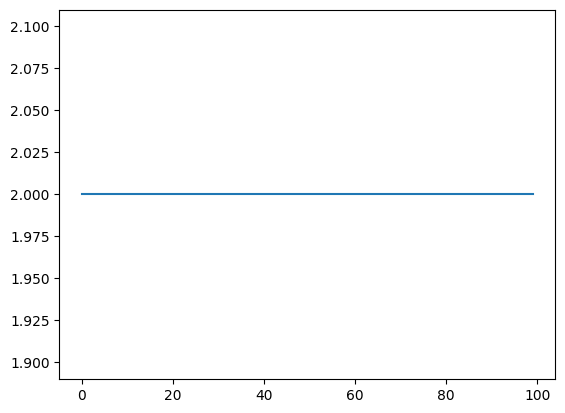

In [9]:
plt.plot(intervention_data[-100:,1], label='b')
plt.show()

This kind of intervention data can be used to calculate ground truth values in the case of causal inference estimation. Such examples can be found in the tutorials on causal inference.